# Introduction

This notebook demonstrates how the NMR-onion version 2.0 work. The data used in this demo is the sample 1 experiment 2 dataset found in the github datafolder. The algoritmn is based around the steps of peak detection, digital filtering a region of interst (ROI), model fitting, model selection and uncertainty estimation.

The first step is to load all the function requried to run the program. The import part is to set the path variable correctly to the folder where you have downloaded all the functions.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore", category=np.ComplexWarning)# disable plot warnings 
path="/home/mabso/Desktop/NMR_Onion_upgraded/NMR Onion Version 2.0/Functions" # set to the path in which NMR onion folder is stored
sys.path.append(path)
from plotting_functions import plot_results, plot_model_bootstrap
from data_import import import_data
from model_caller import onion_model_call,onion_bootstrap_call
from helper_functions import result_csv_noboot, freq_hz,ppm_axis1,t_disrecte,time_series,result_csv
from model_prediction_fuctions import model_auto_select,spectrum_prediction
from peak_detection import onion_peak_detection,integrate_peaks
from onion_filter_experimental import onion_filter_expaned

# Importing the data
To import processed bruker data from Topspin, the import_data function is called. All one need to do is to set the data_path variable as /../dataset_name/exp_number/pdata/1. This will let you import the processed FID, Number of datapoints (N), sweep width in Hz (fs), transmitter position (O1), spectrometor frequecy (SF) and sweep width ppm (fs_ppm). Additionally one can zerofill data if needed by stating true or false. It should be noted that the processed FID does not need to have undergone hard preprocessing, but should be as close to the raw data as possible. The reason the processed FID is loaded is due to the NMR-glue modoule supressing the group delay directly from the pdata.

The time axis (s),frequency axis(hz) and frequency axis(ppm) is then automatically defined by calling the freq_hz,ppm_axis1,t_disrecte,time_series functions based on the import data output.

Currently only Bruker data is supported in this function for other formats the source code of the import function can be cominbed with other vendor formats by replacing the bruker import module from NMRglue with a different NMRglue module. Alternatively one may import a CSV file contaninig spectral data and do an inverse fourier transformation (all other parameters need to be specified manually when doing the CSV option).

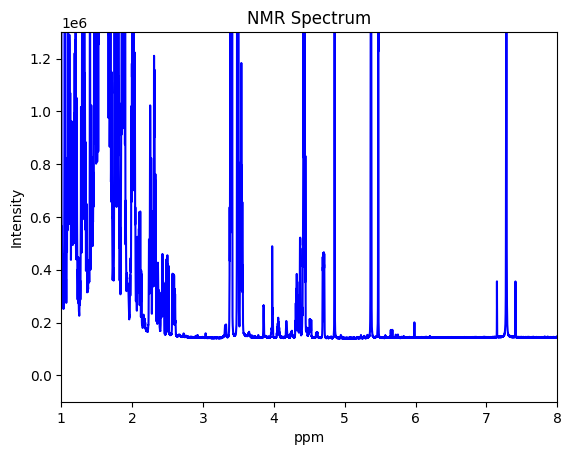

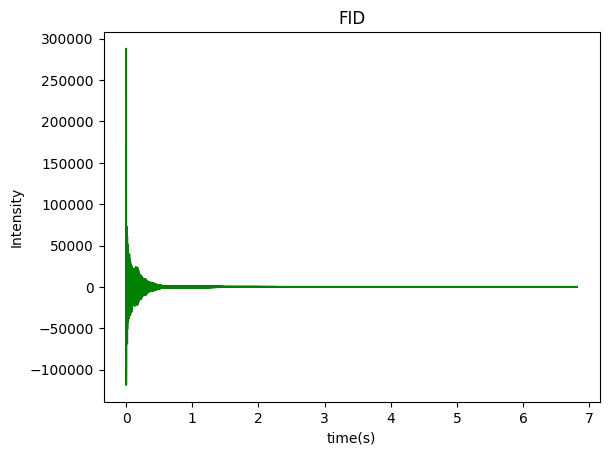

In [2]:
# set your own data_path
data_path="/home/mabso/Desktop/NMR_Onion_upgraded/NMR Onion Version 2.0/Data/DTU800_150922_CHG_MMS052002/10/pdata/1"
sys.path.append(data_path)

# import the data with needed process and aqusition parameters
# import data,data length, sample rate, O1, spectromtor frequency, sweep width (ppm), O1p, zerofill data if needed
data,N,fs,O1,SF,fs_ppm,O1p=import_data(path=data_path,zerofill=True)

# define discrete time (tn) and measure timed (t)
tn=t_disrecte(N)
t=time_series(tn=tn,fs=fs)

# define ppm axis
freq=freq_hz(tn=tn, fs=fs)
ppm_val=ppm_axis1(time=t, O1=O1, fs=fs, fs_ppm=fs_ppm)

# fourier transfrom raw data
y_fft_raw=np.fft.fftshift(np.fft.fft(data))

# check the data import works by plotting
plt.xlabel('ppm')  
plt.ylabel('Intensity')
plt.title("NMR Spectrum")  
plt.plot(ppm_val,y_fft_raw,color="blue")
plt.xlim(1.0,8.0) # zoom x-axis
plt.ylim(-100000,0.13*10**7) # zoom y-axis
plt.show()

# plot the time series
plt.title("FID")  
plt.plot(t,data,color="green")
plt.xlabel('time(s)')  
plt.ylabel('Intensity')
plt.show()

# Peak detection and ROI selection
Following data importing, selection of a ROI is requried for the alogrithm to work computationally effecient. Addtionally a good inital estimates of the frequency values must be given due to the mutimodal nature of the parameter space. The ROI is generated based on a digital filter which cuts out the ROI and adds synthetic noise outside the ROI. Here one needs to select the ROI and noise region for the filter to work. we choose 3.35:3.6 ppm for the ROI and -0.2:-0.1 for the noise region (other regions could also have been choosen).

The filtering function is now updated with three additional agruments: offset, baseline_raw and minimum_filter.

The offset agrument if True, applies a median filter moving down the baseline to 0 if a constant offset is present 

The baseline_raw should be used in combobination with the minimum_filter when a linear baseline drift is present  



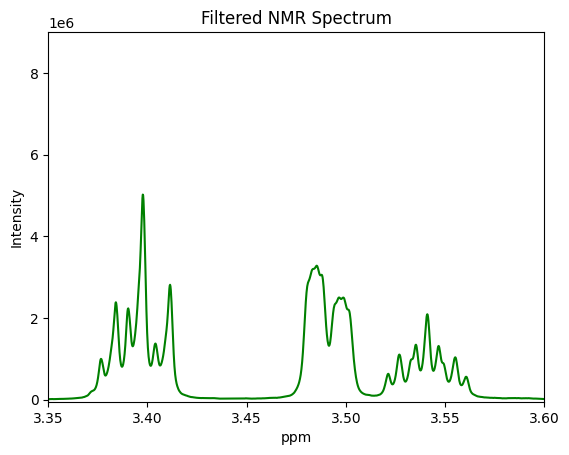

In [3]:
ROI1=np.array([3.35,3.6])
target_ROI=ROI1

high_ppm=target_ROI[1]# set ppm values for region cuts
low_ppm=target_ROI[0]# set ppm values for region cuts

noise_region=[-0.2, -0.1,] # low to high ppm


# apply digital filter to get region of interest and estimated noise level
y_filt,noise_level,baseline_estimate=onion_filter_expaned(low_ppm, high_ppm, noise_region, data, fs, SF, O1p,offset=True,baseline_raw=False,minimum_filter=False)

y_fft_filt=np.fft.fftshift(np.fft.fft((y_filt)))

plt.xlabel('ppm')  
plt.ylabel('Intensity')
plt.title("Filtered NMR Spectrum")  
plt.plot(ppm_val,y_fft_filt,color="green")


plt.xlim(low_ppm,high_ppm) # zoom x-axis
plt.ylim(-49000,0.09*10**8) # zoom y-axis
plt.show()

# Detection and plotting
The peak detection function is in 2.0 updated such that plotting and detection is now mereged. The fiter has been updated to produce less artifacts such as less ripples in the bandpass.

witdh: Controls how large a witdh based on the fwhm of the peaks should be indculeded in the detection. defualt valus is set at 1.0, higher values decrease number of peaks detected (reasonable range:0.8:2.5).

noise_peaks: Controls how large the noise floor should be. defualt value set at 2.0, lowering number increases peaks detected, increasing number decreases number of peaks detected (reasonable range: 1.0:20).

In addtion a new agrument of cut has been added which allow for a removal of peaks below a threshold defined by the smallest peak kept in the data.


No cutoff applied (cut=0). Min value: 556577.1141426357


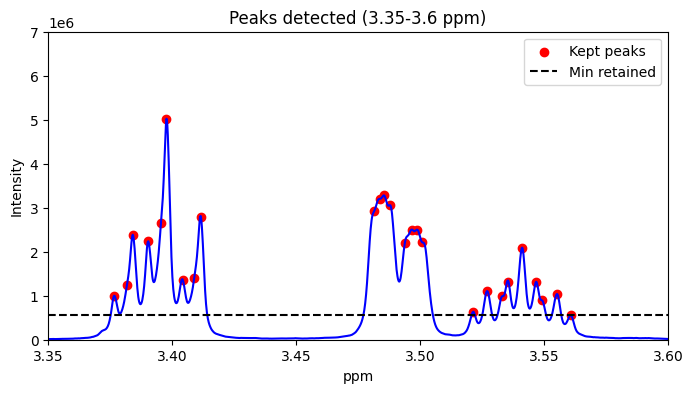

In [4]:
high_ppm=target_ROI[1]# set ppm values for region cuts
low_ppm=target_ROI[0]# set ppm values for region cuts

ylim1=0
ylim2=0.7*10**7.0


omega_hz_filtered=onion_peak_detection(width=1.0, noise_peaks=10,cut=0, ylim1=ylim1, ylim2=ylim2, y_fft_filt=y_fft_filt,
                                       low_ppm=low_ppm, high_ppm=high_ppm, ppm_val=ppm_val,
                                       t=t, fs=fs,freq=freq,y_filt=y_filt,noise_level=noise_level,SF=SF,O1p=O1p)

# Running the models and model selection

In the 2.0 version, the fitting speed have been increased for the three skewed models is run with 20 epochs and a learning rate of 0.1 and an exponential learning rate scheduler is applied to lower the learning rate per epoch. Increased stability in the fitting process have been added meaning convergence should always occur now.

The model selection is based of AIC and BIC from which the lowest value is choosen, pointing back to a specfic model. This is done by the model_auto_selection function, one can either choose this to be based on BIC (defualt) or or AIC by setting BIC=False. A table is also provided should it be needed to see the actual BIC and AIC values.

In [5]:
# model 1
fit1=onion_model_call(model_name="skewed_lorentzian",omega_hz_filtered=omega_hz_filtered,tn_new=tn,t_new=t,fs_new=fs,y_norm=y_filt/np.linalg.norm(y_filt))

# model 2
fit2=onion_model_call(model_name="skewed_pvoigt",omega_hz_filtered=omega_hz_filtered,tn_new=tn,t_new=t,fs_new=fs,y_norm=y_filt/np.linalg.norm(y_filt))

# model 3
fit3=onion_model_call(model_name="skewed_genvoigt",omega_hz_filtered=omega_hz_filtered,tn_new=tn,t_new=t,fs_new=fs,y_norm=y_filt/np.linalg.norm(y_filt))

Epoch 01 | Loss: 9.00396e-01
Epoch 02 | Loss: 4.18704e-03
Epoch 03 | Loss: 3.75727e-03
Epoch 04 | Loss: 3.75726e-03
Epoch 05 | Loss: 3.73319e-03
Epoch 06 | Loss: 3.73313e-03
Epoch 07 | Loss: 3.73313e-03
Epoch 08 | Loss: 3.73313e-03
Early stopping.
3.1397721767425537
Epoch 01 | Loss: 1.31811e-01
Epoch 02 | Loss: 2.61290e-03
Epoch 03 | Loss: 1.33710e-03
Epoch 04 | Loss: 1.09117e-03
Epoch 05 | Loss: 1.00716e-03
Epoch 06 | Loss: 9.87938e-04
Epoch 07 | Loss: 9.87938e-04
Epoch 08 | Loss: 9.84068e-04
Epoch 09 | Loss: 9.84068e-04
Epoch 10 | Loss: 9.84052e-04
Epoch 11 | Loss: 9.82387e-04
Epoch 12 | Loss: 9.82387e-04
Epoch 13 | Loss: 9.82118e-04
Epoch 14 | Loss: 9.82118e-04
Epoch 15 | Loss: 9.82118e-04
Early stopping.
4.741456508636475
Epoch 01 | Loss: 7.46471e-02
Epoch 02 | Loss: 1.58126e-03
Epoch 03 | Loss: 2.64639e-04
Epoch 04 | Loss: 1.74408e-04
Epoch 05 | Loss: 1.54357e-04
Epoch 06 | Loss: 1.40083e-04
Epoch 07 | Loss: 1.30641e-04
Epoch 08 | Loss: 1.27308e-04
Epoch 09 | Loss: 1.23196e-04
Epo

In [6]:
model_compare_BIC=np.array([fit1['BIC_model'],fit2['BIC_model'],fit3['BIC_model']])
model_compare_AIC=np.array([fit1['AIC_model'],fit2['AIC_model'],fit3['AIC_model']])

model_compare_table=pd.DataFrame(({'skewed_lorentzian':(model_compare_BIC[0],model_compare_AIC[0]),
               'skewed_psedou_voigt':(model_compare_BIC[1],model_compare_AIC[1]),
               'skewed_generlized_voigt':(model_compare_BIC[2],model_compare_AIC[2]),
    }))

#make a list of fits
fits=([fit1,fit2,fit3])

par_res,model_name,k=model_auto_select(model_compare_BIC,model_compare_AIC,fits,omega_hz_filtered,BIC=True)
print(model_compare_BIC) # print BIC values, 0 inidicates no covergence
print(model_compare_AIC) # print AIC values, 0 indicates no convergence
print(model_name) # print the best model name


[-1653821.0291538  -1698261.75026981 -1859818.83189427]
[-1655395.12451648 -1700360.54408672 -1861917.62571117]
skewed_genvoigt


# Model output

In the 2.0 version much of the reporting is now automated with the possibility to export the results obtained by NMR-Onion in neat png (dpi 300) or PDF files at a folder of your choice. 

The first code block below shows how one can save the visual results of the best NMR-Onion model. 

Settings:
time_domain=True, returns a plot of the summed FID deconvoultions in the time domain
freq_domain=True, returns a plot of the deconvoultions on the frequency (hz) axis (not O1 corrected)
freq_domain_ppm=True, returns a plot of the deconvoultions on the ppm axis
fshow_peaks=True, returns a plot of the deconvoultion with the identifed peak value marked as a red dot
residuals=True, return the residuals for the fitting in both time and frequency domain (seperate time domain residual plot)

Save_dir= specify the directory to save the plots to. If set as None, no save will be done.

Saved: /home/mabso/testing/time_domain_fid_vs_model.pdf


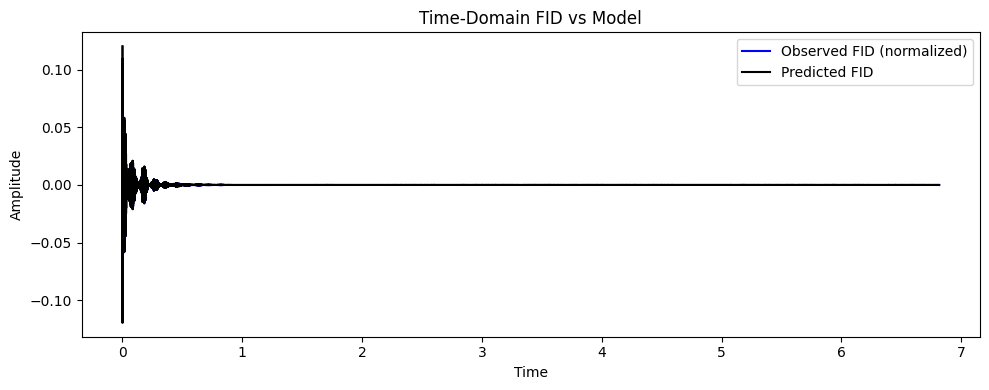

Saved: /home/mabso/testing/time_domain_residuals.pdf


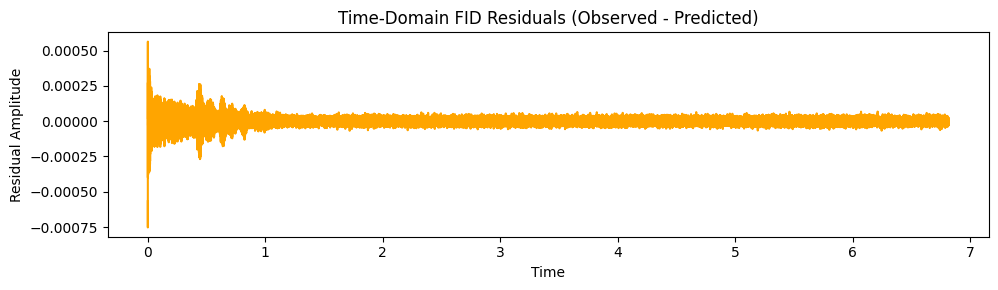

Saved: /home/mabso/testing/frequency_domain_ppm.pdf


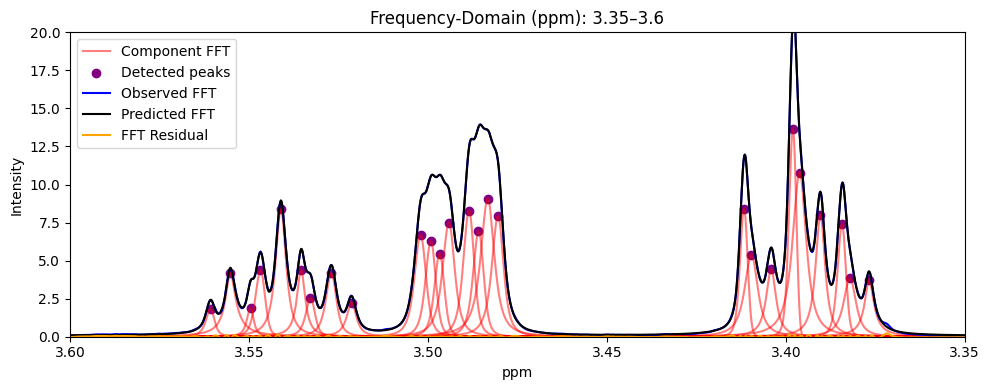

In [7]:
#plot results (good idea to set your save directory to the same everywhere!)
data_path="/home/mabso/testing" # set your current wd here!
sys.path.append(data_path)

par_hat,y_hat,single_sinusoids,amps,phases=spectrum_prediction(model_name,par_res,y_filt,t,k,optional_par=False)

ylim1=0
ylim2=20
xlim1=1100
xlim2=2250

xlim1_ppm=ROI1[0]
xlim2_ppm=ROI1[1]

# plot the results and save to your chosen dir with save_dir choose either pdf or png format
plot_results(xlim1_ppm,xlim2_ppm, ylim1,ylim2,xlim1,xlim2,y_hat=y_hat,y_filt=y_filt,
    t=t,freq=freq,ppm_val=ppm_val,k=k,single_sinusoids=single_sinusoids,time_domain=True,freq_domain=False,
    freq_domain_ppm=True,show_peaks=True, residuals=True,save_dir=data_path,save_format="pdf")


# Automated Integration

In addtion to the deconvoultion results, automated integration of each deconvoluted peak is added in the 2.0 version. As of right now the height of the maximum peak is applied to define peak width for integration. Currently all points with a height ratio of 0.9 to the maximum peak value is considered to be part of the integral.

The visual results can be saved either as a PDF or PNG (300 DPI) using the agruments of:

plot=True, shows the plots
save=True, save the plot
save_dir=data_path, saving directory
filename='auto_integration', call your filename something fitting
format='pdf'  # or 'png'

Plot saved to: /home/mabso/testing/auto_integration.pdf


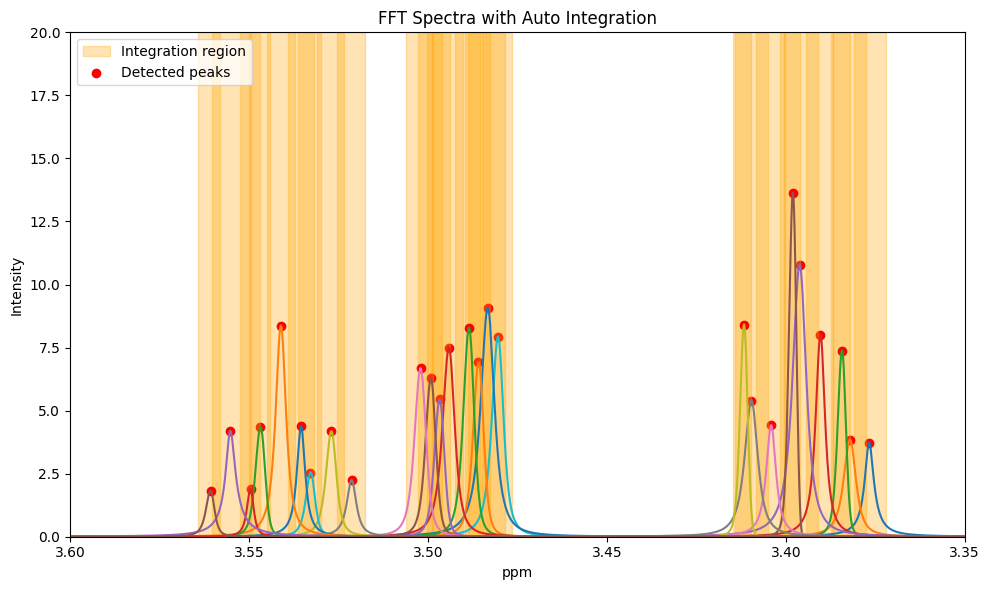

In [8]:
#extract integrals per deconvoulted peak
omega_ppm, omega_hz, int_list= integrate_peaks(
    xlim1_ppm=xlim1_ppm, xlim2_ppm=xlim2_ppm,
    ylim1=ylim1, ylim2=ylim2,
    single_sinusoids=single_sinusoids,
    ppm_val=ppm_val,
    par_res=par_res,
    SF=SF,
    O1p=O1p,
    plot=True,
    save=True,
    save_dir=data_path,
    filename='auto_integration',
    format='pdf'  # or 'png'
)

Finally the results can be saved as a CSV file which will automatically appear in your current working directory as results with a subfolder of ROI1 or however many ROIs you have analyzed. Set output=False if you do not wish to save.

In [9]:
# extract and save your output (currently sent to the fold specified by the plot functions)
data_noboot=result_csv_noboot(single_sinusoids,k,int_list,omega_hz,SF,O1,O1p,save_output=True) # save set to current wd

# Parameter and peak overlap uncertainty
It is also possible to get error of the estimated parameters, this is done by estimating a confidence interval at a user defined level (set CI_level from 0 to 1) and a standard error for each parameter based on B number of bootstrap samples (set B from 1 to inf, recommend B=500+, if B>500 more accuracy, but longer computational time). This might take a while deepending on the size of the ROI.

In [10]:
# run the bootstrap function this takes a while!
# note the parallel implementation does not work yet - set it to false and cores=1
boot_samples=onion_bootstrap_call(parallel=False,cores=1,B=50,par_hat=par_hat,low_ppm=low_ppm,high_ppm=high_ppm,model_name=model_name, CI_level=0.95,SF=SF,O1p=O1p,freq=freq,fs=fs, t=t, k=k, y=y_filt/np.linalg.norm(y_filt))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
42.57778739929199


To save the bootstrap results a simialr function can be utalized the noboot saving function

In [11]:
new_path="/home/mabso/testing/bootstrap" # suggestion is to add an addtional folder for your current wd called bootstrap
sys.path.append(new_path)

data_boot=result_csv(single_sinusoids,boot_samples,k,int_list,omega_hz,SF,O1,O1p,save_output=True) # save set to current wd

As with the previous version of NMR-Onion it is still possible to plot the potentially overlapping peaks identified from the bootstrap function and save the results in a similar fashion as the above save/plotting functions. Should black dots appear it may indicate low reproduceability for said peaks, and thus a new run should be made most likely with a higher width selected. 

However, if one have replicates and the same dots appear it could indicate that the peaks are indeed there, they are just very tightly spaced.


Saved: /home/mabso/testing/bootstrap/model_bootstrap.pdf


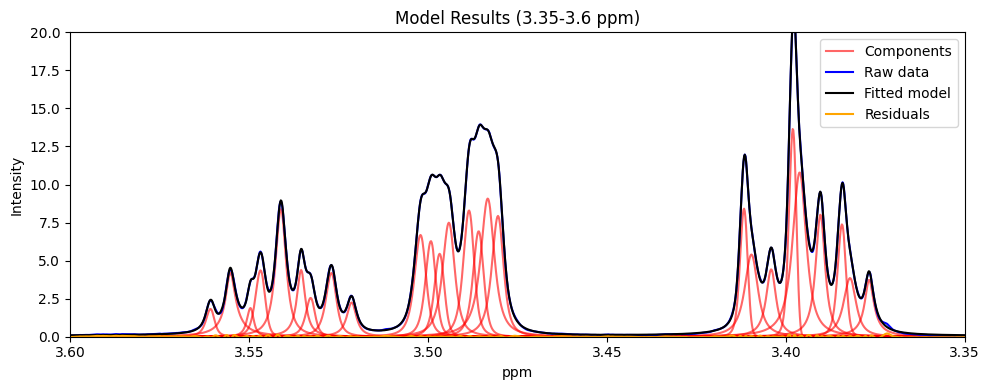

In [12]:
plot_model_bootstrap(
    ppm_val=ppm_val,
    single_sinusoids=single_sinusoids,
    y_hat=y_hat,
    y_filt=y_filt,
    xlim1_ppm=xlim1_ppm,
    xlim2_ppm=xlim2_ppm,
    ylim1=ylim1,
    ylim2=ylim2,
    k=k,
    boot_samples=boot_samples,
    omega_ppm=omega_ppm,
    save_dir=new_path,
    save_format="pdf"  # or 'png'
)